In [62]:
# code to replicate arXiv:1412.2043v2
import numpy as np
from mpmath import mp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root, root_scalar
from collections import namedtuple
from tqdm.notebook import tqdm
import h5py
import util
from numba import jit
# all units should be natural units and in GeV unless otherwise noted

## General Constants and Functions

In [63]:
# constants
M_pl = 2.435e18 # reduced Planck mass [GeV] from wikipedia (https://en.wikipedia.org/wiki/Planck_mass)
m_pl = 1.220910e19 # Planck mass [GeV] from wikipedia (https://en.wikipedia.org/wiki/Planck_mass)
g_star = 427/4 # during reheating from paper
sigma_eff = 1e-31 # [GeV^-2] from paper heavy neutrino exchange 
N_f = 3 # [1] fermion generations
# TODO: renormalization group running?
g_2 = 0.652 # [1] from wikipedia (https://en.wikipedia.org/wiki/Mathematical_formulation_of_the_Standard_Model#Free_parameters)
alpha = g_2**2 / (4 * np.pi) # eq. from paper
c_shaleron = 28/79 # from paper
g_star_0 = 43/11 # from paper
eta_B_observed = 6e-10 # from paper
L_to_B_final_factor = c_shaleron * g_star_0 / g_star # formula from paper (*)
global_epsilon = 1e-3 # global default relative error for convergence check

In [64]:
# helper functions
def eta_L_a_to_eta_B_0(eta_L_a): 
    return L_to_B_final_factor * eta_L_a # formula from paper (*)

def calc_Gamma_a(m_a, f_a):
    m_a = mp.mpf(m_a)
    f_a = mp.mpf(f_a)
    return float(alpha**2 / (64 * np.pi**3) * m_a**3 / f_a**2) # from paper

def calc_temperature(rho_R):
    # in the paper its
    # (np.pi**2 / 3 * g_star * rho_R)**(1/4)
    return (rho_R / g_star * 30 / np.pi**2)**(1/4)

def calc_radiation_energy_density(T):
    return np.pi**2 / 30 * g_star * T**4

def calc_hubble_parameter(rho_total):
    return np.sqrt(rho_total) / (np.sqrt(3) * M_pl) # Friedmann

def calc_rho_R(rho_phi, rho_tot):
    return rho_tot - rho_phi # neglegt axion 

def calc_energy_density_from_hubble(H):
    return 3 * M_pl**2 * H**2 # Friedmann eq.

def calc_lepton_asym_in_eqi(T, mu_eff):
    return 4 / np.pi**2 * mu_eff * T**2 # boltzmann thermodynamics

zeta3 = 1.20206
g_photon = 2
def calc_photon_number_density(T):
    return zeta3 / np.pi**2 * g_photon * T**3 # K&T (3.52)

def calc_asym_parameter(T, n_L):
    n_gamma = calc_photon_number_density(T)
    return n_L / n_gamma # definition

def n_L_to_eta_B_final(T, n_L):
    return -eta_L_a_to_eta_B_0(calc_asym_parameter(T, n_L)) # -sign from defintion of (anti)matter

def calc_Gamma_L(T):
    n_l_eq = 2 / np.pi**2 * T**3
    return 4 * n_l_eq * sigma_eff # is this term only active in a certain range?

In [4]:
# analyical results for reheating
def calc_rho_phi_analytical(t0, t, R_osc, R, rho_phi_0, Gamma_phi):
    return rho_phi_0 * (R / R_osc)**-3 * np.exp(- Gamma_phi * (t - t0)) # K&T (8.30)

def calc_rho_R_analytical(rho_R, t0, t, R_osc, R, rho_phi_0, Gamma_phi):
    start = (6 / np.pi)**0.5 / 10 * m_pl * Gamma_phi * rho_phi_0**0.5 * (R / R_osc)**(-3/2) * (1 - (R / R_osc)**(-5/2)) # K&T (8.32)
    t_RH = 1 / Gamma_phi
    rad_dom = rho_R[-1] * (R / R[-1])**(-4)
    return np.where(t < t_RH, start, rad_dom)

In [5]:
def calc_H_inf_max(f_a):
    return 6e11 * (f_a / 1e15) # paper

def constraints(m_a, f_a, Gamma_phi, H_inf):
    # all from paper:
    assert Gamma_phi <= H_inf, f"Gamma_phi = {Gamma_phi}, H_inf = {H_inf}" # no inflaton decay before the end of inflation
    assert H_inf <= calc_H_inf_max(f_a), f"f_a = {f_a}, H_inf = {H_inf}" # isocurvature
    assert m_a <= H_inf, f"m_a = {m_a}, H_inf = {H_inf}" # axion not part of inflation
    assert m_a >= 8e4*(f_a / 1e15)**(2/3), f"m_a = {m_a}, f_a = {f_a}" # reheating from axion decay large enough  

In [6]:
def calc_end_time(m_a, Gamma_phi, num_osc, larger_than_reheating_by):
    t_osc = 1/(2*m_a) if Gamma_phi >= m_a else 2/(3*m_a)
    axion_period = 2*np.pi/m_a
    t_axion = t_osc + axion_period * num_osc
    t_reheating = 1 / Gamma_phi * larger_than_reheating_by
    return t_axion # max((t_axion, t_reheating))

def calc_start_time(H_inf):
    return 1 / H_inf

## Analytical Solution

In [7]:
def calc_Delta_a(m_a, f_a, Gamma_phi, theta0):
    a0 = theta0 * f_a
    Delta_a_prime = 2*np.pi**2 / alpha * f_a * a0**2 / (m_a * M_pl**2) * min((1, (Gamma_phi / m_a)**0.5))
    Delta_a = max((1, Delta_a_prime))
    return Delta_a

def compute_B_asymmetry_analytic(m_a, f_a, Gamma_phi, theta0=1):
    Delta_phi_prime = (m_a / Gamma_phi)**(5 / 4)
    Delta_phi = max((1, Delta_phi_prime))
    Delta_a = calc_Delta_a(m_a, f_a, Gamma_phi, theta0)
    a0 = f_a * theta0
    eta_L_max = sigma_eff * a0 / (g_star**0.5 * f_a) * m_a * M_pl * min((1, (Gamma_phi / m_a)**0.5))
    T_RH = 2e13*(Gamma_phi / 1e9)**0.5
    T_L = g_star**0.5 / (np.pi * M_pl * sigma_eff)
    kappa = np.where(m_a > Gamma_phi, T_RH / T_L, 0)
    C = np.where(m_a > Gamma_phi, 2.2, 1.5) # factor determined in paper
    eta_L_a = C * Delta_a**-1 * Delta_phi**-1 * eta_L_max * np.exp(-kappa)
    return eta_L_a_to_eta_B_0(eta_L_a)

In [8]:
def print_table():
    theta0 = 1
    f_a_list = [1e12, 1e12, 1e15, 1e15]
    m_a_list = [3e7, 3e6, 1e10, 1e9]
    Gamma_phi_list = [3e6, 3e7, 1e9, 1e10]
    print("f_a, m_a, Gamma_phi, eta_L^a, Delta_a")
    for f_a, m_a, Gamma_phi in zip(f_a_list, m_a_list, Gamma_phi_list):
        print(f"{f_a:e}, {m_a:e}, {Gamma_phi:e}, {compute_B_asymmetry_analytic(m_a, f_a, Gamma_phi):e}, {calc_Delta_a(m_a, f_a, Gamma_phi, theta0):e}")
print_table() # 

f_a, m_a, Gamma_phi, eta_L^a, Delta_a
1.000000e+12, 3.000000e+07, 3.000000e+06, 3.310348e-10, 1.000000e+00
1.000000e+12, 3.000000e+06, 3.000000e+07, 1.376469e-09, 1.000000e+00
1.000000e+15, 1.000000e+10, 1.000000e+09, 8.746394e-09, 3.112049e+00
1.000000e+15, 1.000000e+09, 1.000000e+10, 4.662283e-09, 9.841164e+01


## Numerical Simulation 

In [9]:
SimulationResult = namedtuple("SimulationResult", 
    ["t", "rho_phi", "rho_R", "rho_tot", "T", "H", "R", "theta", "theta_dot", "n_L"])

In [10]:
## numerical implementation of the complete model
theta_index = 3
theta_diff_index = theta_index + 1
n_L_index = theta_diff_index + 1
R_osc = 1.0

def rhs(log_t, y, Gamma_phi, m_a):
    # coordinate transformation
    t = np.exp(log_t)
    rho_phi, rho_tot, R = np.exp(y[:theta_index])
    theta = y[theta_index]
    d_theta_d_log_t = y[theta_diff_index]
    theta_dot = d_theta_d_log_t / t
    rho_R = calc_rho_R(rho_phi, rho_tot)
    T = calc_temperature(rho_R)
    n_L = y[n_L_index]
    
    # Friedmann
    H = calc_hubble_parameter(rho_tot)
    d_log_R_d_log_t = t * H
    
    # reheating energy equations rewritten in rho_phi and roh_tot instead of rho_phi and phi_R and in loglog space
    d_log_rho_phi_d_log_t = - t * (3 * H + Gamma_phi)
    d_log_rho_tot_d_log_t = - H * t * (4 - rho_phi / rho_tot)
    
    # axion eom (Klein Gordon) in theta and log t
    theta_dot2         = - 3 * H * theta_dot - m_a**2 * theta
    d2_theta_d_log_t_2 = d_theta_d_log_t + t**2 * theta_dot2
    
    # Boltzmann eq. for lepton asymmetry
    mu_eff = theta_dot
    n_L_eq = calc_lepton_asym_in_eqi(T, mu_eff)
    Gamma_L = calc_Gamma_L(T)
    d_n_L_d_log_t = t * (- 3 * H * n_L - Gamma_L * (n_L - n_L_eq))
    
    # final result
    return (
        d_log_rho_phi_d_log_t, d_log_rho_tot_d_log_t, 
        d_log_R_d_log_t, 
        d_theta_d_log_t, d2_theta_d_log_t_2,
        d_n_L_d_log_t,
    )

In [48]:
def simulate(m_a, f_a, Gamma_phi, H_inf, theta0=1.0, 
             start=None, end=None, num_osc=15, larger_than_reheating_by=5, solver="DOP853",
             samples=500, fixed_samples=True, converge=True, convergence_epsilon=global_epsilon, debug=False):
    # setup
    if start is None: start = calc_start_time(H_inf)
    if end is None: end = calc_end_time(m_a, Gamma_phi, num_osc, larger_than_reheating_by)
    rho_phi_0 = calc_energy_density_from_hubble(H_inf)
    initial_conditions = np.array([np.log(rho_phi_0), np.log(rho_phi_0), np.log(R_osc), theta0, 0.0, 0.0])
    interval = (start, end) 
    axion_periode = 2*np.pi / m_a
    # arrays for integration step collection
    ys = [np.array([initial_conditions]).T] # np.array([initial_conditions]).T
    ts = [np.array([np.log(start)])] ## np.array([start])
    first = True
    # integrate until convergence of asymmetry (end of leptogensis)
    while True:
        if debug:
            print("interval:", interval, "initial conditions:", initial_conditions)
        sol = solve_ivp(rhs, np.log(interval), initial_conditions, 
                        args=(Gamma_phi, m_a), 
                        t_eval=np.log(np.geomspace(*interval, samples))[:-1] if fixed_samples else None, 
                        method=solver)
        # collect integration steps
        ys.append(sol.y[:, 1:])
        ts.append(sol.t[1:])
        # stop the loop once we are done
        if converge:
            interval = (np.exp(sol.t[-1]), np.exp(sol.t[-1]) + axion_periode * num_osc)
            initial_conditions = sol.y[:, -1]
            if first: # reduce number of samples in the integration result once we start to converge
                samples = max((samples // 10, 10))
                first = False
            else:
                n_L = sol.y[n_L_index]
                rho_phi, rho_tot = np.exp(sol.y[:theta_index - 1])
                T = calc_temperature(calc_rho_R(rho_phi, rho_tot))
                eta_B = n_L_to_eta_B_final(T, n_L)
                i = np.argmax(eta_B)
                j = np.argmin(eta_B) 
                t = np.exp(sol.t)
                delta = np.abs((eta_B[i] - eta_B[j]) / ((eta_B[i] + eta_B[j]) / 2))
                if debug:
                    print("convergence:", delta, "vs", convergence_epsilon)
                if delta < convergence_epsilon:
                    break # stop once convergence criterion is fulfilled 
        else:
            break # dont use the convergence loop if converge == False
    # final result
    t = np.exp(np.concatenate(ts))
    y = np.hstack(ys)
    rho_phi, rho_tot, R = np.exp(y[:theta_index])
    theta, n_L = y[theta_index], y[n_L_index]
    theta_dot = y[theta_diff_index] / t
    rho_R = calc_rho_R(rho_phi, rho_tot)
    T = calc_temperature(rho_R)
    H = calc_hubble_parameter(rho_tot)
    return SimulationResult(t=t, rho_R=rho_R, rho_phi=rho_phi, rho_tot=rho_tot, H=H, R=R, T=T, theta=theta, theta_dot=theta_dot, n_L=n_L)

In [49]:
def count_oscillations(theta):
    s = np.sign(theta) 
    roots = np.sum(s[:-1] != s[1:])
    return roots // 2

def find_local_maxima(theta):
    return np.where((theta[1:-1] > theta[:-2]) & (theta[1:-1] > theta[2:]))[0]

In [50]:
def make_time_plots(m_a, f_a, Gamma_phi, H_inf, show_all=True, save=False, add_title=True, **kwargs):
    sol = t, rho_phi, rho_R, rho_tot, T, H, R, theta, theta_dot, n_L = simulate(m_a, f_a, Gamma_phi, H_inf, **kwargs)
      
    rho_phi_0 = calc_energy_density_from_hubble(H_inf)
    time_label = r"Time, $t \cdot \mathrm{GeV}$"
    T_RH = 2e13 * np.sqrt(Gamma_phi / 1e9) # paper
    T_max = 5e13 * (Gamma_phi / 1e9)**(1/4) * (H_inf / 1e11)**(1/2) # paper
    T_RH_KT = 0.55 * g_star**(-1/4) * (m_pl * Gamma_phi)**0.5 # K&T
    T_max_KT = 0.8 * g_star**(-1/4) * rho_phi_0**(1/8) * (Gamma_phi * m_pl)**(1/4) # K&T
    t_RH = 1 / Gamma_phi
    rho_R_max_Weinberg = 0.139 * Gamma_phi / H_inf * rho_phi_0
    T_max_Weinberg = calc_temperature(rho_R_max_Weinberg)
    osc = True
    try:
        t_osc = t[np.where(m_a > H)[0][0]]
    except:
        osc = False
    
    if show_all:        
        # energy densities
        plt.figure()
        plt.loglog(t, rho_phi, color="tab:blue",   label=r"Numerical: $\rho_\phi$")
        plt.loglog(t, rho_R,   color="tab:orange", label=r"Numerical: $\rho_R$")
        #plt.loglog(t, rho_tot, label=r"Numerical: $\rho_\mathrm{tot}$")
        plt.loglog(t, calc_rho_phi_analytical(calc_start_time(H_inf), t, R_osc, R, rho_phi_0, Gamma_phi), 
                   ls="--", color="tab:blue", label=r"Analytical: $\rho_\phi$")
        plt.loglog(t, calc_rho_R_analytical(rho_R, calc_start_time(H_inf), t, R_osc, R, rho_phi_0, Gamma_phi), 
                   ls="--", color="tab:orange", label=r"Analytical: $\rho_R$")
        plt.axvline(t_RH, label=r"Reheating time, $t_\mathrm{RH}$", color="black", ls="--")
        #plt.axhline(rho_R_max_Weinberg, color="green", ls="-", label="Weinberg max rho_R")
        #plt.axhline(calc_radiation_energy_density(T_RH_KT), color="green", ls="--", label="K&T max rho")
        plt.legend()
        plt.xlabel(time_label)
        plt.ylabel(r"Energy Density, $\rho / \mathrm{GeV}^4$")
        plt.ylim(1e-5, plt.ylim()[1])
        plt.show()

        # temperature
        plt.figure()
        plt.loglog(t, T, label="Temperature", color="tab:blue") # from simulation
        # analytic results for different epochs
        try:
            i_RH = np.where(t_RH <= t)[0][0]
            max_T_idx = np.argmax(T)
            plt.loglog(t[:i_RH], T[max_T_idx]*(R[:i_RH] / R[max_T_idx])**(-3/8), color="tab:blue", ls="--", label="Reheating")
            plt.loglog(t[i_RH:], T[-1] * (R[i_RH:]/R[-1])**-1, color="tab:blue", ls=":", label="Radiation Domination")
        except:
            pass
        # reheating and maximal temperature
        plt.axvline(t_RH, label="Reheating Time", ls="--", color="black")
        #plt.axhline(T_RH, label="Reheating (paper)", ls=":", color="grey") # ~ same as K&T
        plt.axhline(T_RH_KT, label="Reheating T (K&T)", ls="--", color="black")
        #plt.axhline(T_max, label="Max. T (paper)", ls=":", color="red")
        plt.axhline(T_max_KT, label="Max. T (K&T)", ls="--", color="red")
        #plt.axhline(T_max_Weinberg, label="Max. T (Weinberg)", ls="-.", color="red")
        # labels
        plt.legend() # ncol=2)
        plt.xlabel(time_label)
        plt.ylabel(r"Temperature, $T / \mathrm{GeV}$")
        #plt.ylim(plt.ylim()[0], np.max(T) * 2)
        plt.show()

        # scale factor
        plt.figure()
        plt.subplot(1,2,1)
        plt.loglog(t, R / R_osc)
        plt.xlabel(time_label)
        plt.ylabel(r"Scale Parameter, $R / R_\mathrm{osc}$")
        # Hubble parameter
        plt.subplot(1,2,2)
        plt.loglog(t, H, label="Numerical")
        plt.loglog(t, 1 / (2*t), label="Radiation $H = 1/2t$")
        plt.xlabel(time_label)
        plt.ylabel(r"Hubble parameter, $H / \mathrm{GeV}$")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # axion field 
        plt.figure()
        plt.semilogx(t, theta, label=r"Axion field $a(t) / f_a = \theta(t)$")
        plt.xlabel(time_label)
        plt.ylabel(r"Axion angle, $\theta = a(t) / f_a$")
        if osc: plt.axvline(t_osc, label=r"Oscillation Onset: $H_\mathrm{osc} = m_a$", color="black", ls="--")
        plt.axhline(0, label=r"$\theta = 0$", color="black", ls=":")
        plt.legend()
        plt.show()

    # asymmetry parameter
    plt.figure()
    # the minus sign comes from the fact that we are actually computing B - L
    eta_B = n_L_to_eta_B_final(T[1:], n_L[1:])
    plt.loglog(t[1:], eta_B, label="Boltzmann")
    plt.axhline(eta_B[-1], color="black", ls=":", label="Final Value")
    if osc: plt.axvline(t_osc, color="black", ls="--", label="Oscillation Onset")
    plt.xlabel(time_label)
    plt.ylabel(r"Projected Baryon Asymmetry, $\eta_B$")
    plt.legend() # loc="lower right")
    if add_title:
        plt.title(f"$m_a =$ {m_a:.1e} GeV, $\\Gamma_\\phi =$ {Gamma_phi:.1e} GeV,\n$f_a =$ {f_a:.1e} GeV, $H_\\mathrm{{inf}} =$ {H_inf:.1e} GeV")
    plt.tight_layout()
    if save:
        plt.savefig(util.make_plot_path(f"lepto_axion_osc_m_a={m_a:.1e}Gamma_phi={Gamma_phi:.1e}f_a={f_a:.1e}H_inf={H_inf:.1e}_plot.pdf"))
    plt.show()
    
    print("axion oscillations:", count_oscillations(theta))
    print("final asymmetry:", eta_B[-1])
    return sol

In [51]:
f_a = 3e14
H_inf = 2e10

interval: (5e-11, 9.491444627436046e-09) initial conditions: [133.20956537 133.20956537   0.           1.           0.
   0.        ]
interval: (9.392181187400155e-09, 1.8816959148169534e-08) initial conditions: [ 1.21927218e+02  1.21930031e+02  3.75922555e+00 -5.35663260e-03
  9.10302255e-01 -1.89280996e+28]
convergence: 1.060178373119051 vs 0.001
interval: (1.8551994450846813e-08, 2.797677241161619e-08) initial conditions: [ 1.20560398e+02  1.20565963e+02  4.21330551e+00  1.28819905e-04
 -1.02056397e+00 -4.29609559e+27]
convergence: 0.7797398085994938 vs 0.001
interval: (2.7743206256597632e-08, 3.716798421736701e-08) initial conditions: [ 1.19751296e+02  1.19759625e+02  4.48147435e+00  2.53730249e-03
  7.15681505e-01 -1.67374390e+27]
convergence: 0.5627952857815949 vs 0.001
interval: (3.69468076092336e-08, 4.637158557000298e-08) initial conditions: [ 1.19174335e+02  1.19185434e+02  4.67226073e+00 -2.66490780e-03
  1.32899561e-01 -1.26980374e+27]
convergence: 0.5053954550842941 vs 0.0

convergence: 0.12656158585322813 vs 0.001
interval: (4.152404362585473e-07, 4.2466521421931664e-07) initial conditions: [ 1.14182460e+02  1.14309570e+02  6.27317018e+00 -1.42406139e-04
  1.91574797e-01 -9.20916125e+24]
convergence: 0.12421833923118877 vs 0.001
interval: (4.244707498670937e-07, 4.3389552782786307e-07) initial conditions: [ 1.14134751e+02  1.14264744e+02  6.28753464e+00  9.68260762e-06
 -6.13060352e-01 -8.37317042e+24]
convergence: 0.1222966884357702 vs 0.001
interval: (4.3370110927496047e-07, 4.4312588723572983e-07) initial conditions: [ 1.14087987e+02  1.14220865e+02  6.30158413e+00  1.26192968e-04
  2.62091498e-01 -7.68961229e+24]
convergence: 0.12029088282120519 vs 0.001
interval: (4.4293151254704785e-07, 4.523562905078172e-07) initial conditions: [ 1.14042129e+02  1.14177894e+02  6.31533194e+00 -9.95282094e-05
  4.07417022e-01 -8.00594673e+24]
convergence: 0.11832342506728974 vs 0.001
interval: (4.5216195786835446e-07, 4.615867358291238e-07) initial conditions: [ 1.

convergence: 0.061090459483257004 vs 0.001
interval: (7.660139378283249e-07, 7.754387157890943e-07) initial conditions: [ 1.12815112e+02  1.13053441e+02  6.67049038e+00  1.41972751e-05
  3.98878157e-01 -2.63138404e+24]
convergence: 0.06018998880773528 vs 0.001
interval: (7.752452190925584e-07, 7.846699970533278e-07) initial conditions: [ 1.12787383e+02  1.13028685e+02  6.67819507e+00 -5.23966990e-05
 -4.24989791e-02 -2.65633483e+24]
convergence: 0.062330066850621535 vs 0.001
interval: (7.84476514045187e-07, 7.939012920059564e-07) initial conditions: [ 1.12759936e+02  1.13004213e+02  6.68580552e+00  2.34787570e-05
 -3.59986327e-01 -2.50076963e+24]
convergence: 0.06127204747417578 vs 0.001
interval: (7.937078223653784e-07, 8.031326003261478e-07) initial conditions: [ 1.12732765e+02  1.12980019e+02  6.69332396e+00  3.35364168e-05
  2.98777828e-01 -2.43208800e+24]
convergence: 0.06024141121281561 vs 0.001
interval: (8.029391437434487e-07, 8.123639217042181e-07) initial conditions: [ 1.1270

convergence: 0.030014784663505368 vs 0.001
interval: (1.153736779545904e-06, 1.1631615575066734e-06) initial conditions: [ 1.11836832e+02  1.12201980e+02  6.93196334e+00  1.60074937e-05
  1.21357452e-01 -1.19344348e+24]
convergence: 0.029574625293052263 vs 0.001
interval: (1.1629684476473806e-06, 1.17239322560815e-06) initial conditions: [ 1.11817085e+02  1.12185300e+02  6.93700715e+00 -1.52590799e-05
  1.27550144e-01 -1.19739102e+24]
convergence: 0.07169592894430098 vs 0.001
interval: (1.1722001218242076e-06, 1.181624899784977e-06) initial conditions: [ 1.11797463e+02  1.12168748e+02  6.94200924e+00 -9.92231811e-06
 -9.44078180e-02 -1.17579252e+24]
convergence: 0.020541868387360475 vs 0.001
interval: (1.1814318019809534e-06, 1.1908565799417228e-06) initial conditions: [ 1.11777964e+02  1.12152321e+02  6.94697025e+00  1.08627404e-05
 -7.36547646e-02 -1.14408636e+24]
convergence: 0.019664946185456906 vs 0.001
interval: (1.19066348802442e-06, 1.2000882659851894e-06) initial conditions: [

convergence: 0.005993633100965945 vs 0.001
interval: (1.5414711774027385e-06, 1.5508959553635079e-06) initial conditions: [ 1.11096728e+02  1.11592564e+02  7.11404231e+00 -9.59723157e-07
 -4.96594887e-03 -6.96273994e+23]
convergence: 0.006464368822322389 vs 0.001
interval: (1.5507030381457744e-06, 1.5601278161065438e-06) initial conditions: [ 1.11080943e+02  1.11579937e+02  7.11776516e+00  6.34925927e-07
 -1.18955920e-02 -6.87789036e+23]
convergence: 0.0061939380103232826 vs 0.001
interval: (1.559934902303806e-06, 1.5693596802645754e-06) initial conditions: [ 1.11065229e+02  1.11567381e+02  7.12146465e+00  4.78485191e-07
  1.32383556e-02 -6.80228166e+23]
convergence: 0.006015200611259205 vs 0.001
interval: (1.5691667698364944e-06, 1.5785915477972638e-06) initial conditions: [ 1.11049584e+02  1.11554897e+02  7.12514105e+00 -9.43349796e-07
  2.19357335e-03 -6.73352703e+23]
convergence: 0.0063166803065602605 vs 0.001
interval: (1.5783986407042161e-06, 1.5878234186649856e-06) initial condi

convergence: 0.0039918324228955795 vs 0.001
interval: (1.9015159584905437e-06, 1.910940736451313e-06) initial conditions: [ 1.10526474e+02  1.11146934e+02  7.24411935e+00 -6.12096641e-08
  1.03917856e-03 -4.70090244e+23]
convergence: 0.00408312493380335 vs 0.001
interval: (1.9107479278888786e-06, 1.920172705849648e-06) initial conditions: [ 1.10512915e+02  1.11136611e+02  7.24710036e+00 -2.53837343e-08
 -1.23236236e-03 -4.65872067e+23]
convergence: 0.0040900993686746314 vs 0.001
interval: (1.9199798995357236e-06, 1.929404677496493e-06) initial conditions: [ 1.10499402e+02  1.11126335e+02  7.25006606e+00  6.19949417e-08
 -3.86596145e-05 -4.61696855e+23]
convergence: 0.003947624493707863 vs 0.001
interval: (1.929211873409494e-06, 1.9386366513702635e-06) initial conditions: [ 1.10485935e+02  1.11116106e+02  7.25301660e+00 -1.92655413e-08
  1.05162624e-03 -4.57632440e+23]
convergence: 0.003962274288104232 vs 0.001
interval: (1.9384438494889066e-06, 1.947868627449676e-06) initial conditions

convergence: 0.0031011126562588377 vs 0.001
interval: (2.2892603916308535e-06, 2.298685169591623e-06) initial conditions: [ 1.09992042e+02  1.10750028e+02  7.35763927e+00  3.15036184e-10
  9.61320201e-06 -3.33804373e+23]
convergence: 0.0030813297979589895 vs 0.001
interval: (2.298492439874156e-06, 2.3079172178349255e-06) initial conditions: [ 1.09980090e+02  1.10741391e+02  7.36008475e+00 -1.68908443e-10
  2.14451060e-06 -3.31351867e+23]
convergence: 0.003062730721088106 vs 0.001
interval: (2.3077244896709566e-06, 2.317149267631726e-06) initial conditions: [ 1.09968169e+02  1.10732786e+02  7.36251971e+00 -1.89504052e-11
  6.87197319e-07 -3.28927669e+23]
convergence: 0.003043788225118309 vs 0.001
interval: (2.3169565410088344e-06, 2.3263813189696038e-06) initial conditions: [ 1.09956279e+02  1.10724215e+02  7.36494423e+00  3.52518145e-11
 -1.84697341e-06 -3.26531500e+23]
convergence: 0.0030250038789997797 vs 0.001
interval: (2.326188593875529e-06, 2.3356133718362985e-06) initial conditi

convergence: 0.002457915092180037 vs 0.001
interval: (2.649311321794691e-06, 2.6587360997554605e-06) initial conditions: [ 1.09547160e+02  1.10435745e+02  7.44592479e+00  3.67218497e-11
  4.44118823e-06 -2.55780976e+23]
convergence: 0.002443762361321795 vs 0.001
interval: (2.6585434226112925e-06, 2.667968200572062e-06) initial conditions: [ 1.09536273e+02  1.10428241e+02  7.44801526e+00 -3.82695800e-12
 -4.30201414e-07 -2.54173619e+23]
convergence: 0.002429880028932059 vs 0.001
interval: (2.6677755245889092e-06, 2.6772003025496786e-06) initial conditions: [ 1.09525409e+02  1.10420763e+02  7.45009791e+00  1.86966139e-12
  3.76950377e-07 -2.52582309e+23]
convergence: 0.002416076605084306 vs 0.001
interval: (2.6770076277195115e-06, 2.686432405680281e-06) initial conditions: [ 1.09514568e+02  1.10413310e+02  7.45217280e+00  1.65747153e-11
 -7.31198143e-07 -2.51006834e+23]
convergence: 0.0024023941523680526 vs 0.001
interval: (2.6862397319951642e-06, 2.6956645099559336e-06) initial conditio

convergence: 0.0018988651438749586 vs 0.001
interval: (3.0832211983249074e-06, 3.092645976285677e-06) initial conditions: [ 1.09058381e+02  1.10107818e+02  7.53653286e+00  1.53338479e-09
 -9.18548064e-05 -1.94627881e+23]
convergence: 0.0018881203171204738 vs 0.001
interval: (3.092453346201036e-06, 3.1018781241618055e-06) initial conditions: [ 1.09048441e+02  1.10101339e+02  7.53830766e+00  2.05766097e-09
  7.24085519e-05 -1.93588981e+23]
convergence: 0.0018746024377512137 vs 0.001
interval: (3.1016854949351028e-06, 3.111110272895872e-06) initial conditions: [ 1.09038517e+02  1.10094879e+02  7.54007672e+00 -2.61644760e-09
  2.98247326e-05 -1.92559641e+23]
convergence: 0.0018697315685064744 vs 0.001
interval: (3.1109176445219995e-06, 3.120342422482769e-06) initial conditions: [ 1.09028611e+02  1.10088438e+02  7.54184009e+00  5.33067347e-11
 -7.94986991e-05 -1.91538103e+23]
convergence: 0.0018595468580939072 vs 0.001
interval: (3.1201497949566767e-06, 3.129574572917446e-06) initial condit

convergence: 0.0014975741318590404 vs 0.001
interval: (3.50790081788075e-06, 3.5173255958415196e-06) initial conditions: [ 1.08617461e+02  1.09827740e+02  7.61272646e+00 -2.25113594e-10
  1.10564450e-06 -1.54676957e+23]
convergence: 0.0014904912754831248 vs 0.001
interval: (3.517133000552399e-06, 3.5265577785131683e-06) initial conditions: [ 1.08608215e+02  1.09822026e+02  7.61426964e+00  3.07095952e-11
 -7.07265953e-07 -1.53958878e+23]
convergence: 0.0014829061839365543 vs 0.001
interval: (3.526365183887238e-06, 3.5357899618480075e-06) initial conditions: [ 1.08598983e+02  1.09816327e+02  7.61580842e+00  5.07878792e-11
  1.88121766e-06 -1.53246190e+23]
convergence: 0.0014754655805324602 vs 0.001
interval: (3.5355973678818015e-06, 3.545022145842571e-06) initial conditions: [ 1.08589763e+02  1.09810643e+02  7.61734282e+00 -1.62718148e-11
 -4.48120216e-06 -1.52538822e+23]
convergence: 0.0014681870803233985 vs 0.001
interval: (3.5448295525326355e-06, 3.554254330493405e-06) initial conditi

convergence: 0.0012252278717680889 vs 0.001
interval: (3.886420816804068e-06, 3.895845594764837e-06) initial conditions: [ 1.08248499e+02  1.09604778e+02  7.67262706e+00  1.26481259e-11
  7.78524987e-09 -1.29118194e+23]
convergence: 0.0012192727263099787 vs 0.001
interval: (3.895653024084982e-06, 3.905077802045751e-06) initial conditions: [ 1.08239741e+02  1.09599611e+02  7.67400764e+00 -2.21525238e-14
 -9.71231790e-07 -1.28581856e+23]
convergence: 0.0012134578535944224 vs 0.001
interval: (3.904885231906433e-06, 3.914310009867202e-06) initial conditions: [ 1.08230994e+02  1.09594455e+02  7.67538465e+00  2.20997334e-11
 -8.75623907e-06 -1.28049117e+23]
convergence: 0.0012076592132707913 vs 0.001
interval: (3.914117440265856e-06, 3.923542218226625e-06) initial conditions: [ 1.08222257e+02  1.09589312e+02  7.67675813e+00  5.31835034e-11
 -4.20697699e-07 -1.27519947e+23]
convergence: 0.0012017527534751435 vs 0.001
interval: (3.923349649160731e-06, 3.9327744271215e-06) initial conditions: [

convergence: 0.0010182351183272986 vs 0.001
interval: (4.246477279348726e-06, 4.255902057309495e-06) initial conditions: [ 1.07914404e+02  1.09411712e+02  7.72398258e+00 -1.49658081e-10
  2.37273044e-05 -1.10597094e+23]
convergence: 0.0010139748782447976 vs 0.001
interval: (4.2557095059701516e-06, 4.2651342839309205e-06) initial conditions: [ 1.07906027e+02  1.09406977e+02  7.72523625e+00 -3.27711401e-10
 -9.17916687e-06 -1.10179881e+23]
convergence: 0.0010096869531382652 vs 0.001
interval: (4.264941733044483e-06, 4.274366511005252e-06) initial conditions: [ 1.07897659e+02  1.09402252e+02  7.72648696e+00  1.60504573e-10
 -6.24655397e-06 -1.09765176e+23]
convergence: 0.0010046407660967889 vs 0.001
interval: (4.274173960569769e-06, 4.283598738530538e-06) initial conditions: [ 1.07889299e+02  1.09397538e+02  7.72773472e+00  7.04753946e-11
  2.31130348e-06 -1.09353045e+23]
convergence: 0.000999997195621758 vs 0.001


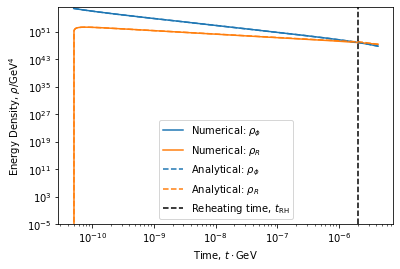

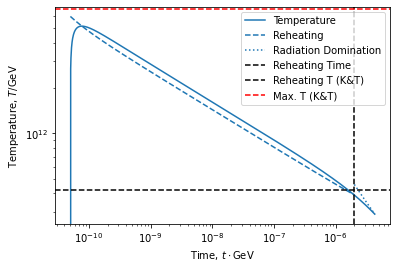

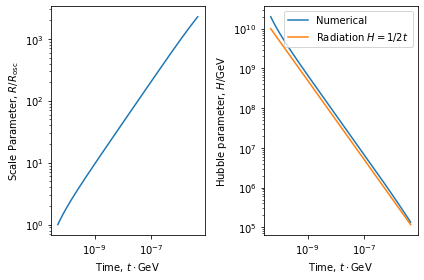

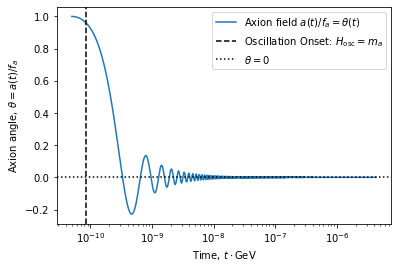

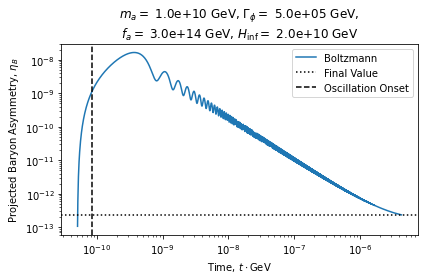

axion oscillations: 6773
final asymmetry: 2.358037302242958e-13


In [47]:
sol = make_time_plots(1e10, f_a, 5e5, H_inf, show_all=True, debug=True, end=None, converge=True, solver="DOP853");
#take = 300
#plt.semilogx(sol.t[-take:], sol.theta[-take:])

interval: (5e-11, 9.474777960769379e-06) initial conditions: [133.20956537 133.20956537   0.           1.           0.
   0.        ]
interval: (9.2468261048235e-06, 1.867160406559288e-05) initial conditions: [-8.13413980e+02  1.07568499e+02  7.31531208e+00 -2.82773796e-02
  5.82511371e-01 -6.52685080e+26]
convergence: 0.003805929561306697 vs 0.001
interval: (1.840574003981728e-05, 2.7830518000586658e-05) initial conditions: [-1.73033823e+03  1.06191354e+02  7.65959817e+00  1.27239044e-02
 -2.19324433e+00 -2.31465433e+26]
convergence: 0.001531478704348527 vs 0.001
interval: (2.7596667221910417e-05, 3.702144518267979e-05) initial conditions: [-2.65003859e+03  1.05381162e+02  7.86214632e+00  4.96449755e-04
  3.56970218e+00 -1.25889862e+26]
convergence: 0.0008972772306385508 vs 0.001


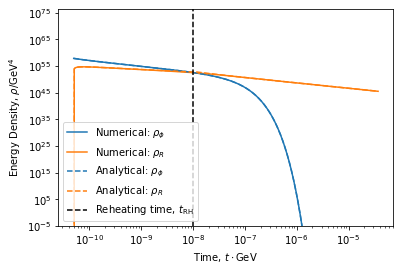

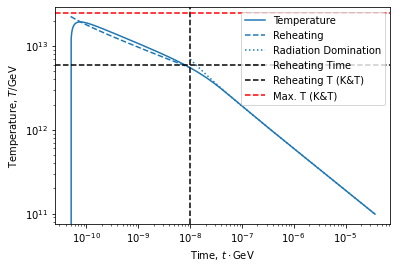

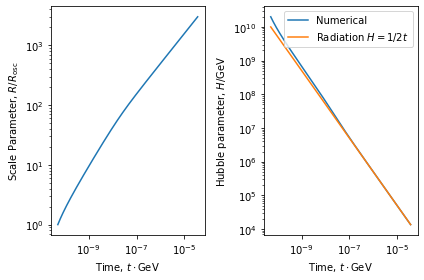

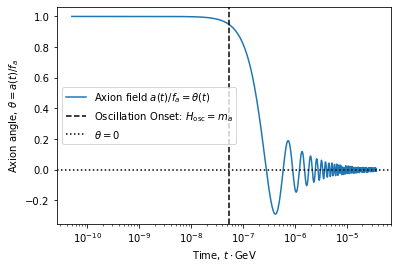

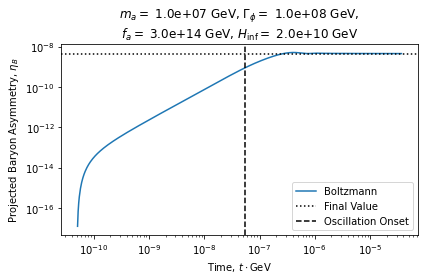

axion oscillations: 58
final asymmetry: 4.5764025617823714e-09


In [15]:
sol = make_time_plots(1e7, f_a, 1e8, H_inf, save=False, show_all=True, debug=True)

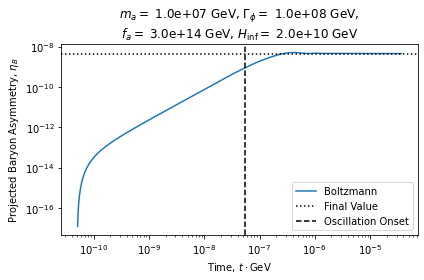

axion oscillations: 58
final asymmetry: 4.581508497401496e-09


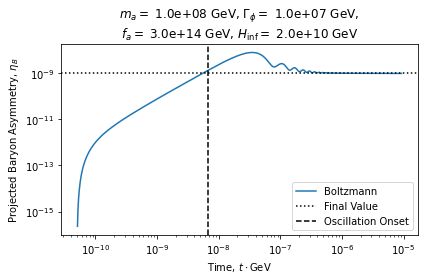

axion oscillations: 146
final asymmetry: 9.569308457010853e-10


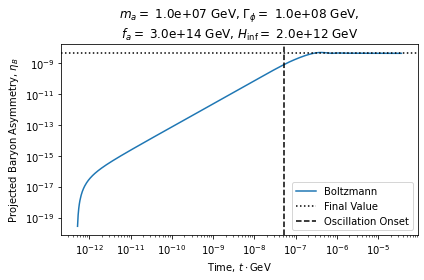

axion oscillations: 58
final asymmetry: 4.5813578072630566e-09


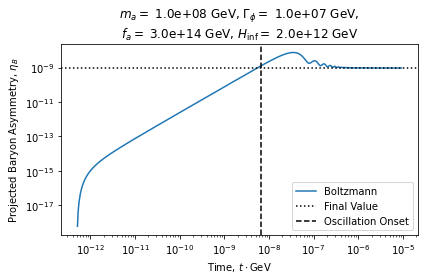

axion oscillations: 146
final asymmetry: 9.570913289917135e-10


In [52]:
for m_a, Gamma_phi in [(1e7, 1e8), (1e8, 1e7)]:
    make_time_plots(m_a, f_a, Gamma_phi, H_inf, save=True, show_all=False)
for m_a, Gamma_phi in [(1e7, 1e8), (1e8, 1e7)]:
    make_time_plots(m_a, f_a, Gamma_phi, 2e12, save=True, show_all=False)

## Axion Decay and Entropy Production

In [53]:
def rhs_axion_decay(log_t, y, Gamma_a):
    rho_R, rho_a, R = np.exp(y)
    t = np.exp(log_t)
    H = calc_hubble_parameter(rho_a + rho_R)
    d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)
    d_log_rho_a_d_log_t = - t * (3 * H + Gamma_a)
    d_log_R_d_log_t = t * H
    return d_log_rho_R_d_log_t, d_log_rho_a_d_log_t, d_log_R_d_log_t

R_0 = 1.0

AxionDecayResult = namedtuple("AxionDecayResult", ["t", "rho_R", "rho_a", "R", "T", "n_L"])

def axion_energy_density(theta, theta_dot, m_a, f_a):
    rho_pot = 0.5 * m_a**2 * f_a**2 * theta**2
    rho_kin = 0.5 * f_a**2 * theta_dot**2
    return rho_kin + rho_pot

def simulate_axion_decay(m_a, f_a, bg_sol, end=None, 
                         samples=500, converge=True, convergence_epsilon=global_epsilon):
    Gamma_a = calc_Gamma_a(m_a, f_a)

    start = np.log(bg_sol.t[-1])
    t_axion_decay = 1 / Gamma_a
    end = end if end is not None else np.log(t_axion_decay * 1e3)
    interval = (start, end)

    # at the maximum the axion only has potential energy
    rho_a_initial = axion_energy_density(bg_sol.theta[-1], bg_sol.theta_dot[-1], m_a, f_a)

    rho_R_initial = bg_sol.rho_R[-1]
    initial_conditions = (np.log(rho_R_initial), np.log(rho_a_initial), np.log(R_0))
    
    axion_decay_sol = solve_ivp(rhs_axion_decay, interval, initial_conditions, 
                    args=(Gamma_a,), t_eval=np.linspace(*interval, samples))
        
    t = np.exp(axion_decay_sol.t)
    rho_R, rho_a, R = np.exp(axion_decay_sol.y)
    n_L_start = bg_sol.n_L[-1]
    n_L = n_L_start * (R_0 / R)**3
    T = calc_temperature(rho_R)
    
    # convergence check
    d_n_L_dt = (n_L[-1] - n_L[-2]) / (t[-1] - t[-2])
    n_L_timescale = np.abs(d_n_L_dt / n_L[-1])
    assert n_L_timescale < convergence_epsilon, f"m_a = {m_a}, f_a = {f_a}"
    
    return AxionDecayResult(t=t, rho_R=rho_R, rho_a=rho_a, R=R, T=T, n_L=n_L)

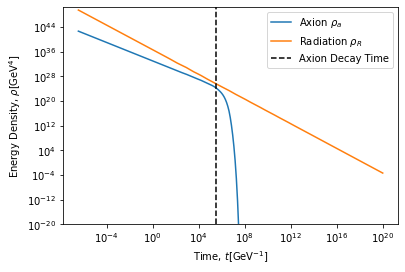

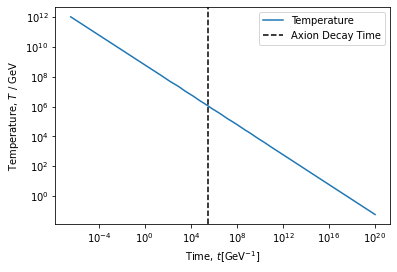

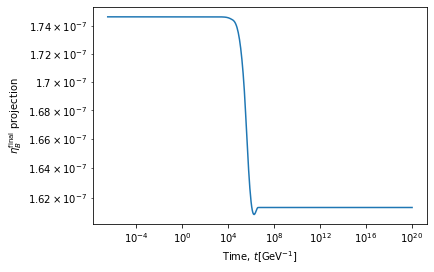

In [54]:
Gamma_phi = 8e9
m_a = 8e9

bg_sol = simulate(m_a, f_a, Gamma_phi, H_inf)
t, rho_R, rho_a, R, T, n_L = simulate_axion_decay(m_a, f_a, bg_sol, end=np.log(1e20))
eta_B_final_proj = n_L_to_eta_B_final(T, n_L)
t_axion_decay = 1 / calc_Gamma_a(m_a, f_a)

plt.figure()
plt.loglog(t, rho_a, label=r"Axion $\rho_a$")
plt.loglog(t, rho_R, label=r"Radiation $\rho_R$")
plt.axvline(t_axion_decay, color="black", ls="--", label="Axion Decay Time")
plt.ylim(1e-20, rho_R[0]*10)
time_label = r"Time, $t [\mathrm{GeV}^{-1}]$"
plt.xlabel(time_label)
plt.ylabel(r"Energy Density, $\rho [\mathrm{GeV}^4]$")
plt.legend()
plt.show()

plt.figure()
T = calc_temperature(rho_R)
plt.loglog(t, T, label="Temperature")
plt.axvline(t_axion_decay, color="black", ls="--", label="Axion Decay Time")
plt.xlabel(time_label)
plt.ylabel(r"Temperature, $T$ / GeV")
plt.legend()
plt.show()
    
plt.figure()
plt.loglog(t, eta_B_final_proj)
plt.xlabel(time_label)
plt.ylabel(r"$\eta_B^\mathrm{final}$ projection")
plt.show()

In [55]:
def store_data(filename, axis_arrays, result_array):
    filepath = util.make_output_data_path(filename)
    hdf5_file = h5py.File(filepath, "w")
    
    
def load_data(filename):
    pass

## Final $\eta_B$ numerical

In [57]:
def compute_B_asymmetry(m_a, f_a, Gamma_phi, H_inf, theta0=1.0):
    bg_res = simulate(m_a, f_a, Gamma_phi, H_inf, theta0=theta0, samples=10, debug=False, fixed_samples=False)
    axion_decay_res = simulate_axion_decay(m_a, f_a, bg_res, samples=10)
    return n_L_to_eta_B_final(axion_decay_res.T[-1], axion_decay_res.n_L[-1])

## Contour Plot

In [58]:
def sample_parameter_space(func, f_a, H_inf, min_Gamma_phi=1e6, max_Gamma_phi=1e10, min_m_a=2e5, max_m_a=1e10,
                         num_m_a_samples=30, num_Gamma_phi_samples=31):
    Gamma_phi_s = np.geomspace(min_Gamma_phi, max_Gamma_phi, num_Gamma_phi_samples)
    m_a_s = np.geomspace(min_m_a, max_m_a, num_m_a_samples)
    eta_B_s = np.array([[func(m_a, f_a, Gamma_phi, H_inf) for m_a in m_a_s] for Gamma_phi in tqdm(Gamma_phi_s)])
    return m_a_s, Gamma_phi_s, eta_B_s

In [59]:
f_a = 3e14
H_inf = 2e10
# time: 11.5.min
m_a_s, Gamma_phi_s, eta_B_numerical = sample_parameter_space(compute_B_asymmetry, f_a, H_inf)
_, _, eta_B_analytical = sample_parameter_space(lambda *args: compute_B_asymmetry_analytic(*args[:-1]), f_a, H_inf)

<ipython-input-53-56ebecc68d4e>:2: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
<ipython-input-53-56ebecc68d4e>:5: RuntimeWarning: divide by zero encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)
/home/jana/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ivp/rk.py:109: RuntimeWarning: invalid value encountered in true_divide
  return norm(self._estimate_error(K, h) / scale)
<ipython-input-53-56ebecc68d4e>:5: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)
<ipython-input-53-56ebecc68d4e>:5: RuntimeWarning: overflow encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)


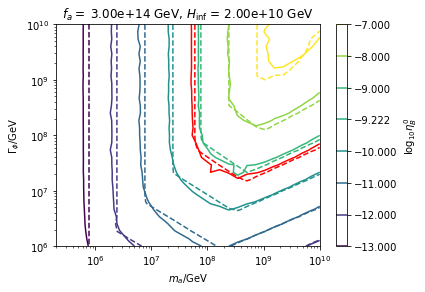

In [60]:
levels = np.sort(np.concatenate([np.arange(-13, -7 + 1), [np.log10(eta_B_observed)]]))

# analytic result from paper
CS = plt.contour(m_a_s, Gamma_phi_s, np.log10(eta_B_analytical), levels=levels, linestyles="dashed")
plt.colorbar().set_label(r"$\log_{10} \eta_B^0$")
CS.collections[np.where(CS.levels == np.log10(eta_B_observed))[0][0]].set_color("red")

# numerical result
CS2 = plt.contour(m_a_s, Gamma_phi_s, np.log10(eta_B_numerical), levels=levels)
CS2.collections[np.where(CS2.levels == np.log10(eta_B_observed))[0][0]].set_color("red")

# labels
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"$m_a / \mathrm{GeV}$")
plt.ylabel(r"$\Gamma_\phi / \mathrm{GeV}$")
plt.tight_layout()
plt.title(f"$f_a =$ {f_a:.2e} GeV, $H_\\mathrm{{inf}}$ = {H_inf:.2e} GeV")
plt.savefig(util.make_plot_path("sbg_leptogenesis_axion_osc_contour_plot.pdf"))

## Search for the Observed Asymmetry and Compute Possible Parameter Volume

In [67]:
def search_bracket(f, hint, max_trys=10, eps=1):
    delta = eps
    for i in range(max_trys):
        delta += eps
        interval = l, r = hint - delta, hint + delta
        if np.sign(f(l)) != np.sign(f(r)):
            return interval
    raise RuntimeError("interval not found")
    
def order(xs, ys):
    if len(xs) == 0:
        return np.array([]), np.array([])
    i = np.argmax(ys)
    x, y = xs[i], ys[i]
    xs = list(xs); ys = list(ys)
    xs.remove(x); ys.remove(y)
    ordered_x = [x]; ordered_y = [y]
    while xs:
        i = min(range(len(xs)), key=lambda i: (xs[i] - x)**2 + (ys[i] - y)**2)
        ordered_x.append(xs[i]); ordered_y.append(ys[i])
        del xs[i]; del ys[i]
    return np.array(ordered_x), np.array(ordered_y)

In [113]:
def compute_correct_curve(f_a, H_inf, samples=15, min_val=5e5, use_numerical=False):
    m_a_s       = np.geomspace(min_val, H_inf, samples)
    Gamma_phi_s = np.geomspace(min_val, H_inf, samples)
    correct_Gamma_phis = []
    correct_m_as       = []
    # for Gamma_phi in tqdm(Gamma_phi_s):
    for Gamma_phi in Gamma_phi_s:
        goal_m_a_analyical = lambda log_m_a: np.log(compute_B_asymmetry_analytic(np.exp(log_m_a), f_a, Gamma_phi)) - np.log(eta_B_observed)
        goal_m_a_numerical = lambda log_m_a: np.log(compute_B_asymmetry(np.exp(log_m_a), f_a, Gamma_phi, H_inf)) - np.log(eta_B_observed)
        try:
            ans = root_scalar(goal_m_a_analyical, bracket=(np.log(m_a_s[0]), np.log(m_a_s[-1])))
            if use_numerical and ans.converged:
                bracket = search_bracket(goal_m_a_numerical, ans.root)
                ans = root_scalar(goal_m_a_numerical, bracket=bracket)
                if ans.converged:
                    correct_Gamma_phis.append(Gamma_phi)
                    correct_m_as.append(np.exp(ans.root))
            if not use_numerical and ans.converged:
                correct_Gamma_phis.append(Gamma_phi)
                correct_m_as.append(np.exp(ans.root)) 
        except ValueError:
            pass

    # for m_a in tqdm(m_a_s):
    for m_a in m_a_s:
        goal_Gamma_phi_analyical = lambda log_Gamma_phi: np.log(compute_B_asymmetry_analytic(m_a, f_a, np.exp(log_Gamma_phi))) - np.log(eta_B_observed)
        goal_Gamma_phi_numerical = lambda log_Gamma_phi: np.log(compute_B_asymmetry(m_a, f_a, np.exp(log_Gamma_phi), H_inf)) - np.log(eta_B_observed)
        try:
            ans = root_scalar(goal_Gamma_phi_analyical, bracket=(np.log(Gamma_phi_s[0]), np.log(Gamma_phi_s[-1])))
            if use_numerical and ans.converged:
                bracket = search_bracket(goal_Gamma_phi_numerical, ans.root)
                ans = root_scalar(goal_Gamma_phi_numerical, bracket=bracket)
                if ans.converged:
                    correct_Gamma_phis.append(np.exp(ans.root))
                    correct_m_as.append(m_a)
            if not use_numerical:
                correct_Gamma_phis.append(Gamma_phi)
                correct_m_as.append(np.exp(ans.root)) 
        except ValueError:
            pass
    return order(correct_m_as, correct_Gamma_phis)

In [111]:
f_a_s = np.geomspace(4e10, 3e14, 3)
correct_curves = [compute_correct_curve(f_a, calc_H_inf_max(f_a), use_numerical=False) for f_a in tqdm(f_a_s)]

Text(0, 0.5, '$\\Gamma_\\phi$ / GeV')

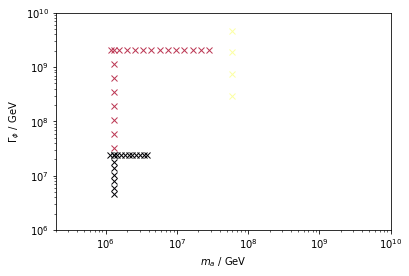

In [112]:
cmap = plt.get_cmap("inferno")
for x, f_a, correct_curve in zip(np.linspace(0, 1, len(f_a_s)), f_a_s, correct_curves):
    plt.loglog(*correct_curve, "x", color=cmap(x))
plt.xlim(np.min(m_a_s), np.max(m_a_s))
plt.ylim(np.min(Gamma_phi_s), np.max(Gamma_phi_s))
plt.xlabel("$m_a$ / GeV")
plt.ylabel("$\\Gamma_\\phi$ / GeV")

(1000000.0, 10000000000.0)

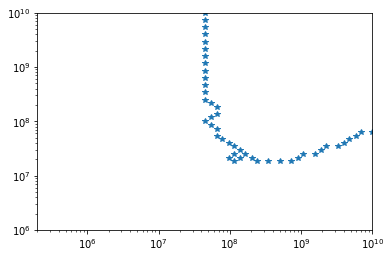

In [109]:
roots = [(Gamma_phi, (m_a_s[i] + m_a_s[i + 1]) / 2) 
    for k, Gamma_phi in enumerate(Gamma_phi_s)
    for i in range(len(m_a_s) - 1) 
        if (eta_B_numerical[k, i] > eta_B_observed) != (eta_B_numerical[k, i + 1] > eta_B_observed)
]
roots += [((Gamma_phi_s[i] + Gamma_phi_s[i + 1]) / 2, m_a) 
    for k, m_a in enumerate(m_a_s)
    for i in range(len(Gamma_phi_s) - 1) 
        if (eta_B_numerical[i, k] > eta_B_observed) != (eta_B_numerical[i + 1, k] > eta_B_observed)
]
plt.loglog([M for _, M in roots], [G for G, _ in roots], "*")
plt.xlim(min(m_a_s), max(m_a_s))
plt.ylim(min(Gamma_phi_s), max(Gamma_phi_s))

In [88]:
eta_B_numerical.shape

(31, 30)